# Time Series Forecasting of Sales

**Objective:** Build a complete end‑to‑end **data science project** to forecast `Sales` using classical time‑series models (ARIMA, SARIMA), machine learning models (Random Forest, XGBoost), and a deep learning model (LSTM).

Dataset columns detected:
- **DateTime** (time index)
- **Sales** (target)
- Additional features: Temperature, Holiday, Promotion, Store_Visits

This notebook focuses on the full **data science workflow**:
1. Problem understanding & data loading
2. Exploratory data analysis (EDA)
3. Time‑series preprocessing & feature engineering
4. Modeling with ARIMA & SARIMA
5. Modeling with ML regressors (Random Forest, XGBoost)
6. Modeling with LSTM (deep learning)
7. Model evaluation & comparison
8. Simple deployment‑style prediction function for new data.

## 1. Imports & setup

In [1]:
!pip install pmdarima xgboost tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 4)
sns.set(style='whitegrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.6 MB/s eta 0:00:00


## 2. Load and inspect data

In [2]:
data_path = '/content/time_series_data.csv'
df = pd.read_csv(data_path)

df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df = df.set_index('DateTime')

print('Shape:', df.shape)
df.head()

Shape: (500, 5)


,Sales,Temperature,Holiday,Promotion,Store_Visits
DateTime,,,,,
2020-01-01,104.967142,29.630888,0,1,93.171724
2020-01-02,203.584499,34.547083,0,0,165.857959
2020-01-03,310.061384,18.007162,0,0,261.446953
2020-01-04,425.291682,27.814846,0,0,397.879192
2020-01-05,522.950149,21.746787,0,1,586.245039


### 2.1 Basic exploratory analysis

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-01 to 2021-05-14
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sales         500 non-null    float64
 1   Temperature   500 non-null    float64
 2   Holiday       500 non-null    int64  
 3   Promotion     500 non-null    int64  
 4   Store_Visits  500 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 23.4 KB


In [29]:
df.describe()

,Sales,Temperature,Holiday,Promotion,Store_Visits
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,25036.277023,25.159131,0.098000,0.312000,24974.747429
std,14503.389016,4.889986,0.297612,0.463774,14851.324617
min,104.967142,11.515567,0.000000,0.000000,93.171724
25%,12501.119999,22.023541,0.000000,0.000000,12109.773345
50%,25037.638320,25.142658,0.000000,0.000000,24790.892817
75%,37601.848360,28.256211,0.000000,1.000000,36823.678982
max,50034.189973,38.161910,1.000000,1.000000,59235.644481


In [32]:
df.isna().sum()

,0
Sales,0
Temperature,0
Holiday,0
Promotion,0
Store_Visits,0


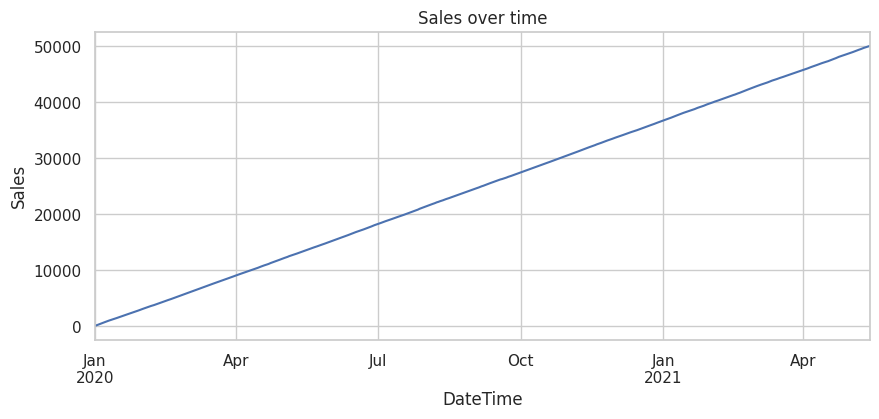

In [33]:
df['Sales'].plot(title='Sales over time')
plt.ylabel('Sales')
plt.show()

## 3. Time‑series properties: trend, seasonality, stationarity

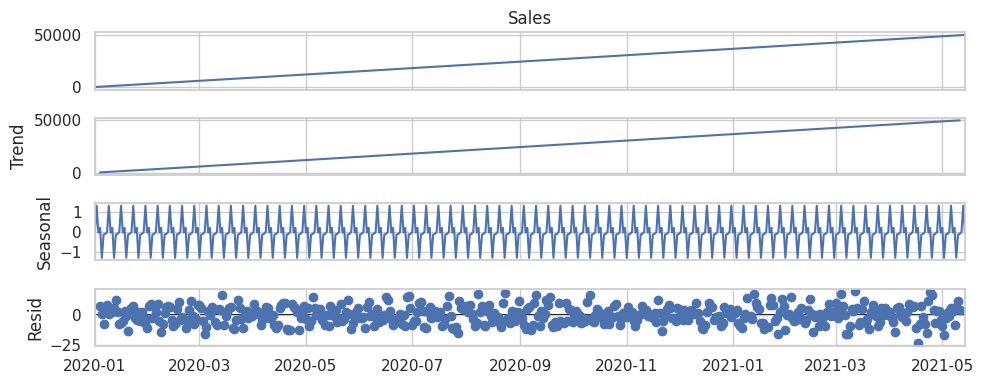

In [6]:
decomp = seasonal_decompose(df['Sales'], model='additive', period=7)
decomp.plot()
plt.tight_layout()
plt.show()

In [7]:
result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.5172919835758889
p-value: 0.9853893032011892


## 4. Train–test split

Train shape: (400, 5)
Test shape: (100, 5)


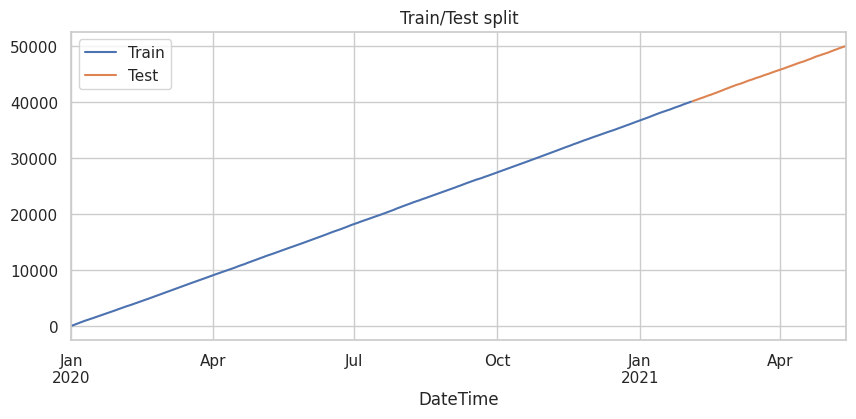

In [8]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print('Train shape:', train.shape)
print('Test shape:', test.shape)

train['Sales'].plot(label='Train')
test['Sales'].plot(label='Test')
plt.legend()
plt.title('Train/Test split')
plt.show()

## 5. ARIMA model (classical time‑series)

In [9]:
arima_model = auto_arima(train['Sales'],
                         seasonal=False,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2947.751, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2941.209, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2942.302, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2942.288, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4814.586, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2944.301, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.654 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1468.604
Date:                Thu, 20 Nov 2025   AIC                           2941.209
Time:                        22:18:08   BIC                           2949.186
Sample:                    01-01-2020   HQIC                          2944.368
          

ARIMA -> MAE: 42.592, RMSE: 48.226


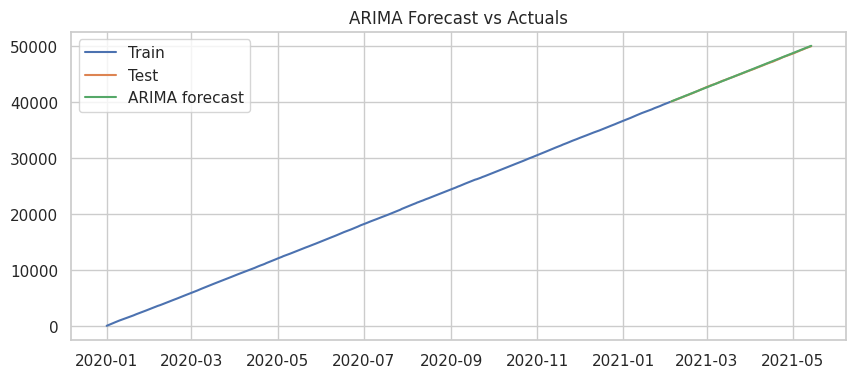

In [10]:
arima_forecast = pd.Series(
    arima_model.predict(n_periods=len(test)),
    index=test.index
)

def evaluate_forecast(y_true, y_pred, name='model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}')
    return mae, rmse

evaluate_forecast(test['Sales'], arima_forecast, 'ARIMA')

plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(arima_forecast, label='ARIMA forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.show()

## 6. SARIMA model (seasonal ARIMA)

In [11]:
# Here we assume weekly seasonality (period=7). Adjust (p,d,q)(P,D,Q,7) if needed.
sarima_model = sm.tsa.statespace.SARIMAX(
    train['Sales'],
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  400
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1419.161
Date:                           Thu, 20 Nov 2025   AIC                           2848.321
Time:                                   22:18:17   BIC                           2868.061
Sample:                               01-01-2020   HQIC                          2856.152
                                    - 02-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0794      0.926     -0.086      0.932      -1.895       1.736
ma.L1          0.0260      0.929      0.028

SARIMA -> MAE: 44.545, RMSE: 50.684


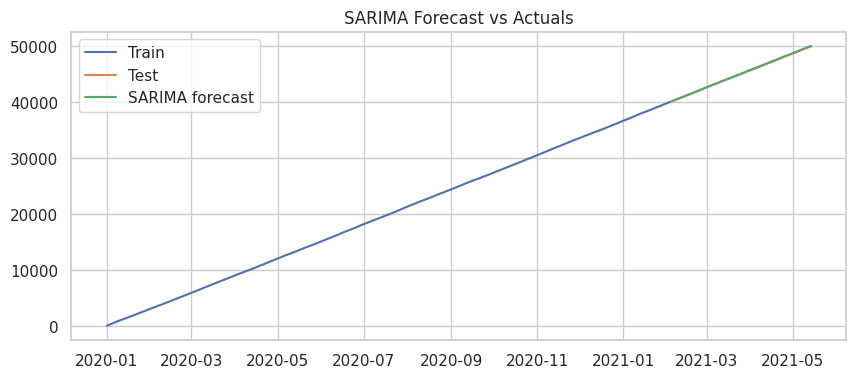

In [12]:
sarima_forecast = sarima_model.get_forecast(steps=len(test))
sarima_pred = sarima_forecast.predicted_mean

evaluate_forecast(test['Sales'], sarima_pred, 'SARIMA')

plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(sarima_pred, label='SARIMA forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actuals')
plt.show()

## 7. Machine Learning models (Random Forest & XGBoost)
To use tree‑based ML models, we convert the time series into a **supervised** learning problem by creating lag features and using calendar features.

In [13]:
def create_lag_features(data, target_col='Sales', lags=7):
    df_ml = data.copy()
    for lag in range(1, lags+1):
        df_ml[f'lag_{lag}'] = df_ml[target_col].shift(lag)

    # Calendar features
    df_ml['dayofweek'] = df_ml.index.dayofweek
    df_ml['month'] = df_ml.index.month
    df_ml['dayofmonth'] = df_ml.index.day

    df_ml = df_ml.dropna()
    return df_ml

df_ml = create_lag_features(df)
df_ml.head()

,Sales,Temperature,Holiday,Promotion,Store_Visits,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,dayofweek,month,dayofmonth
DateTime,,,,,,,,,,,,,,,
2020-01-08,844.075255,20.680046,0,0,774.350865,736.400907,620.608779,522.950149,425.291682,310.061384,203.584499,104.967142,2,1,8
2020-01-09,939.380511,25.242608,0,0,1101.612923,844.075255,736.400907,620.608779,522.950149,425.291682,310.061384,203.584499,3,1,9
2020-01-10,1044.806111,20.845249,0,1,1001.766385,939.380511,844.075255,736.400907,620.608779,522.950149,425.291682,310.061384,4,1,10
2020-01-11,1140.171934,26.352284,0,0,951.857839,1044.806111,939.380511,844.075255,736.400907,620.608779,522.950149,425.291682,5,1,11
2020-01-12,1235.514637,24.748809,0,0,1293.369594,1140.171934,1044.806111,939.380511,844.075255,736.400907,620.608779,522.950149,6,1,12


In [14]:
train_ml = df_ml.iloc[:train_size]
test_ml = df_ml.iloc[train_size:]

feature_cols = [c for c in df_ml.columns if c != 'Sales']

X_train, y_train = train_ml[feature_cols], train_ml['Sales']
X_test, y_test = test_ml[feature_cols], test_ml['Sales']

X_train.shape, X_test.shape

((400, 14), (93, 14))

### 7.1 Random Forest Regressor

In [15]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_mae, rf_rmse = evaluate_forecast(y_test, rf_pred, 'RandomForest')

RandomForest -> MAE: 4871.901, RMSE: 5549.571


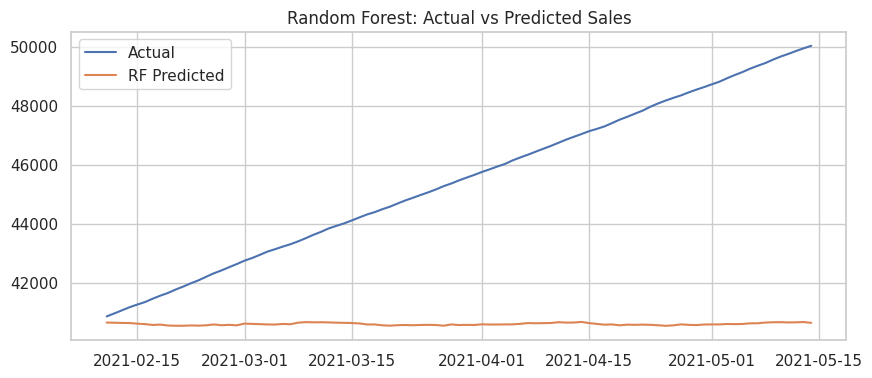

In [16]:
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, rf_pred, label='RF Predicted')
plt.legend()
plt.title('Random Forest: Actual vs Predicted Sales')
plt.show()

### 7.2 XGBoost Regressor

In [17]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_mae, xgb_rmse = evaluate_forecast(y_test, xgb_pred, 'XGBoost')

XGBoost -> MAE: 4908.119, RMSE: 5591.045


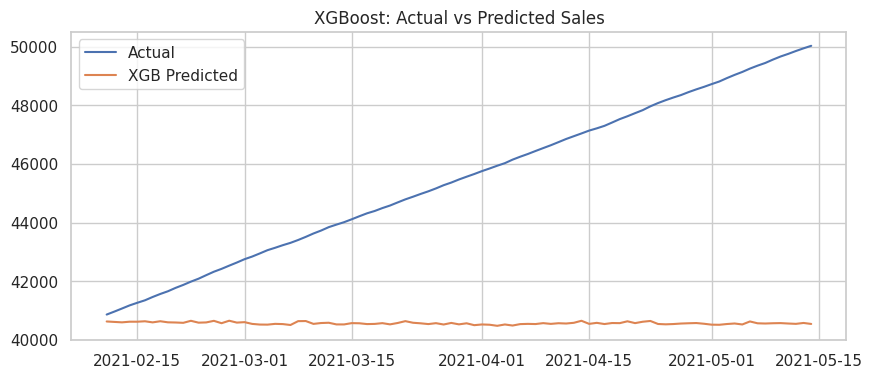

In [18]:
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_pred, label='XGB Predicted')
plt.legend()
plt.title('XGBoost: Actual vs Predicted Sales')
plt.show()

## 8. LSTM (Deep Learning)
We build an LSTM model that learns temporal patterns from the `Sales` series (optionally with additional features).

In [19]:
# For simplicity we only use the Sales series for LSTM here.
series = df[['Sales']].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series)

def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 14
X, y = create_sequences(series_scaled, window_size)

split_index = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:split_index], X[split_index:]
y_train_lstm, y_test_lstm = y[:split_index], y[split_index:]

# Reshape to [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

X_train_lstm.shape, X_test_lstm.shape

((388, 14, 1), (98, 14, 1))

In [20]:
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7368e-07 - val_loss: 7.9827e-06
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.6612e-07 - val_loss: 7.2566e-06
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4381e-07 - val_loss: 1.2207e-05
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3214e-07 - val_loss: 8.0386e-06
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.0922e-07 - val_loss: 8.5024e-06
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1042e-07 - val_loss: 7.2505e-06
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4702e-07 - val_loss: 6.0436e-06
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.8300e-07 - val_loss: 4.6954e-06
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7457e-07 - val_loss: 8.4855e-06
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5721e-07 - val_loss: 1.2712e-05
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.6927e-0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM -> MAE: 348.048, RMSE: 367.512


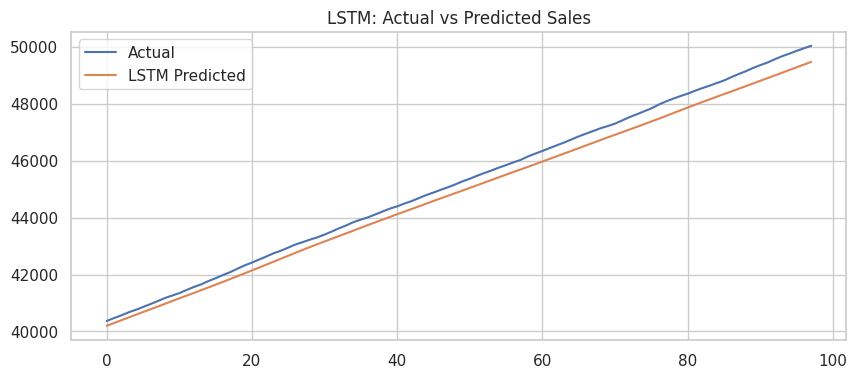

In [25]:
lstm_pred_scaled = lstm_model.predict(X_test_lstm)

# Inverse scale
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

lstm_mae = mean_absolute_error(y_test_inv, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred))
print(f'LSTM -> MAE: {lstm_mae:.3f}, RMSE: {lstm_rmse:.3f}')

plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_pred, label='LSTM Predicted')
plt.legend()
plt.title('LSTM: Actual vs Predicted Sales')
plt.show()

## 9. Model comparison

In [26]:
metrics = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'RandomForest', 'XGBoost', 'LSTM'],
    'MAE': [
        mean_absolute_error(test['Sales'], arima_forecast),
        mean_absolute_error(test['Sales'], sarima_pred),
        rf_mae,
        xgb_mae,
        lstm_mae
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(test['Sales'], arima_forecast)),
        np.sqrt(mean_squared_error(test['Sales'], sarima_pred)),
        rf_rmse,
        xgb_rmse,
        lstm_rmse
    ]
})
metrics

,Model,MAE,RMSE
0,ARIMA,42.591624,48.226245
1,SARIMA,44.545412,50.683597
2,RandomForest,4871.900888,5549.570566
3,XGBoost,4908.119265,5591.045388
4,LSTM,348.047821,367.512053


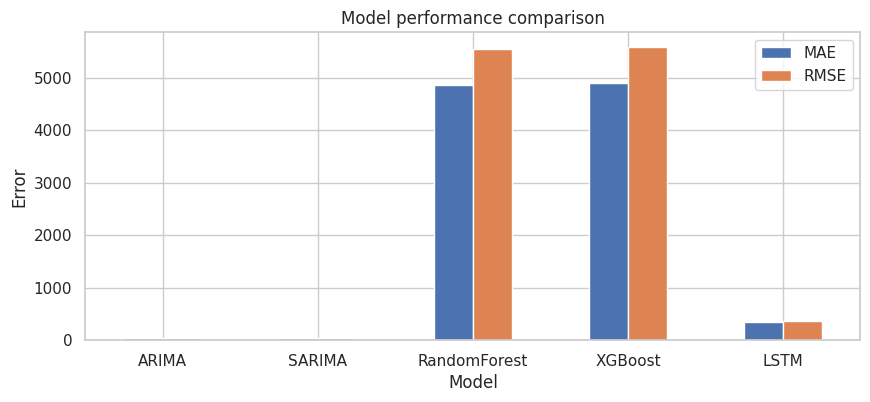

In [27]:
metrics.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar')
plt.title('Model performance comparison')
plt.ylabel('Error')
plt.xticks(rotation=0)
plt.show()

## 10. Simple deployment‑style prediction
Here we define helper functions that, once the models are trained, can be used inside a simple API or web app to forecast future `Sales`.

In [34]:
import joblib

# Example: save best ML model & scaler
joblib.dump(rf, 'best_rf_model.joblib')
joblib.dump(xgb, 'best_xgb_model.joblib')
lstm_model.save('lstm_sales_model.h5')
joblib.dump(scaler, 'lstm_scaler.joblib')

def predict_next_n_days_rf(model, last_df, n_days=7):
    """Use the RF model to predict next n days given the last part of the dataframe."""
    preds = []
    tmp = last_df.copy()
    for _ in range(n_days):
        tmp_ml = create_lag_features(tmp)[feature_cols]
        x_last = tmp_ml.iloc[[-1]]
        y_hat = model.predict(x_last)[0]
        next_index = tmp.index[-1] + pd.Timedelta(days=1)
        new_row = tmp.iloc[[-1]].copy()
        new_row.index = [next_index]
        new_row['Sales'] = y_hat
        tmp = pd.concat([tmp, new_row])
        preds.append((next_index, y_hat))
    return pd.DataFrame(preds, columns=['Date', 'Predicted_Sales']).set_index('Date')

# Example usage (uncomment to run after training):
# future_rf = predict_next_n_days_rf(rf, df[['Sales', 'Temperature', 'Holiday', 'Promotion', 'Store_Visits']], n_days=7)
# future_rf

---
### Summary
- We followed a **full data science workflow** for a time‑series `Sales` forecasting problem.
- Built and compared **ARIMA**, **SARIMA**, **Random Forest**, **XGBoost**, and **LSTM** models.
- Evaluated models using **MAE** and **RMSE**.
- Prepared a simple **deployment‑ready interface** via saved models and helper prediction functions.

You can now customize this notebook (hyperparameters, features, window sizes) and use it as a core **Data Science portfolio project**.